# Generate fragment merges

Notebook shows how the fragment network is used to generate possible merges from a test set of 12 fragment pairs (identified from the Mpro dataset).
## Imports

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd

sys.path.insert(1, '/home/sabsr3/xchem/fragment_network_merges/scripts')
from FindMerges import *
from DescriptorFilter import *
from EmbeddingFilter import *
from OverlapFilter import *
import itertools

## Load test set fragments

Test set fragments were manually identified from the Mpro dataset. Test set consists of a 'target' molecule (an existing merge), and two 'child' fragments, fragment A and fragment B. For the majority of the molecules, fragment B is a truncated version of the target molecule.

In [2]:
# load the test set csv
df = pd.read_csv('testset.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df

,molecule,molecule_smiles,fraga,fraga_smiles,fragb,fragb_smiles
0,x0678,O=C(CC1CCCCC1)Nc1cccnc1,x0107,CC(=O)Nc1cnccc1C,x0678t,NC(=O)CC1CCCCC1
1,x2569,N#Cc1cncc(CC(=O)Nc2cccnc2)c1,x0305,CCNc1ccc(C#N)cn1,x2569t,NC(=O)Cc1cccnc1
2,x2572,Cc1ccncc1NC(=O)Cc1cccc(C#N)c1,x0107,CC(=O)Nc1cnccc1C,x2572t,N#Cc1cccc(CC(N)=O)c1
3,x2608,Cc1ccc(NC(=O)Nc2cccnc2)s1,x0434,O=C(Nc1ccccc1)Nc1cccnc1,x2608t,Cc1ccc(NC(N)=O)s1
4,x2643,O=C(Cc1ccc(Cl)s1)Nc1cccnc1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,x2643t,NC(=O)Cc1ccc(Cl)s1
5,x2649,Cc1ccncc1NC(=O)C(C)c1cccc(Cl)c1,x0107,CC(=O)Nc1cnccc1C,x2649t,CC(C(N)=O)c1cccc(Cl)c1
6,x2908,Cc1ccncc1NC(=O)Nc1cccc(Cl)c1,x0107,CC(=O)Nc1cnccc1C,x2908t,NC(=O)Nc1cccc(Cl)c1
7,x2912,Cc1ccncc1NC(=O)C(C)c1cccc(C#N)c1,x0107,CC(=O)Nc1cnccc1C,x2912t,CC(C(N)=O)c1cccc(C#N)c1
8,x3080,Cc1ccncc1NC(=O)CN(C)S(=O)(=O)c1cccc2cccnc12,x0107,CC(=O)Nc1cnccc1C,x3080t,CN(CC(N)=O)S(=O)(=O)c1cccc2cccnc12
9,x2600,N#Cc1cccc(CC(=O)Nc2cccnc2)c1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,x1249,N#Cc1ccc(CNC(=O)N2CCOCC2)cc1


In [3]:
def mols_from_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    return mols

In [4]:
# get smiles of fragments and convert to rdkit mols
target_smiles = list(df['molecule_smiles'])
target_mols = mols_from_smiles(target_smiles)
target_ids = [str(i) for i in df['molecule']]

fraga_smiles = list(df['fraga_smiles'])
fraga_mols = mols_from_smiles(fraga_smiles)
fraga_ids = [str(i) for i in df['fraga']]

fragb_smiles = list(df['fragb_smiles'])
fragb_mols = mols_from_smiles(fragb_smiles)
fragb_ids = [str(i) for i in df['fragb']]

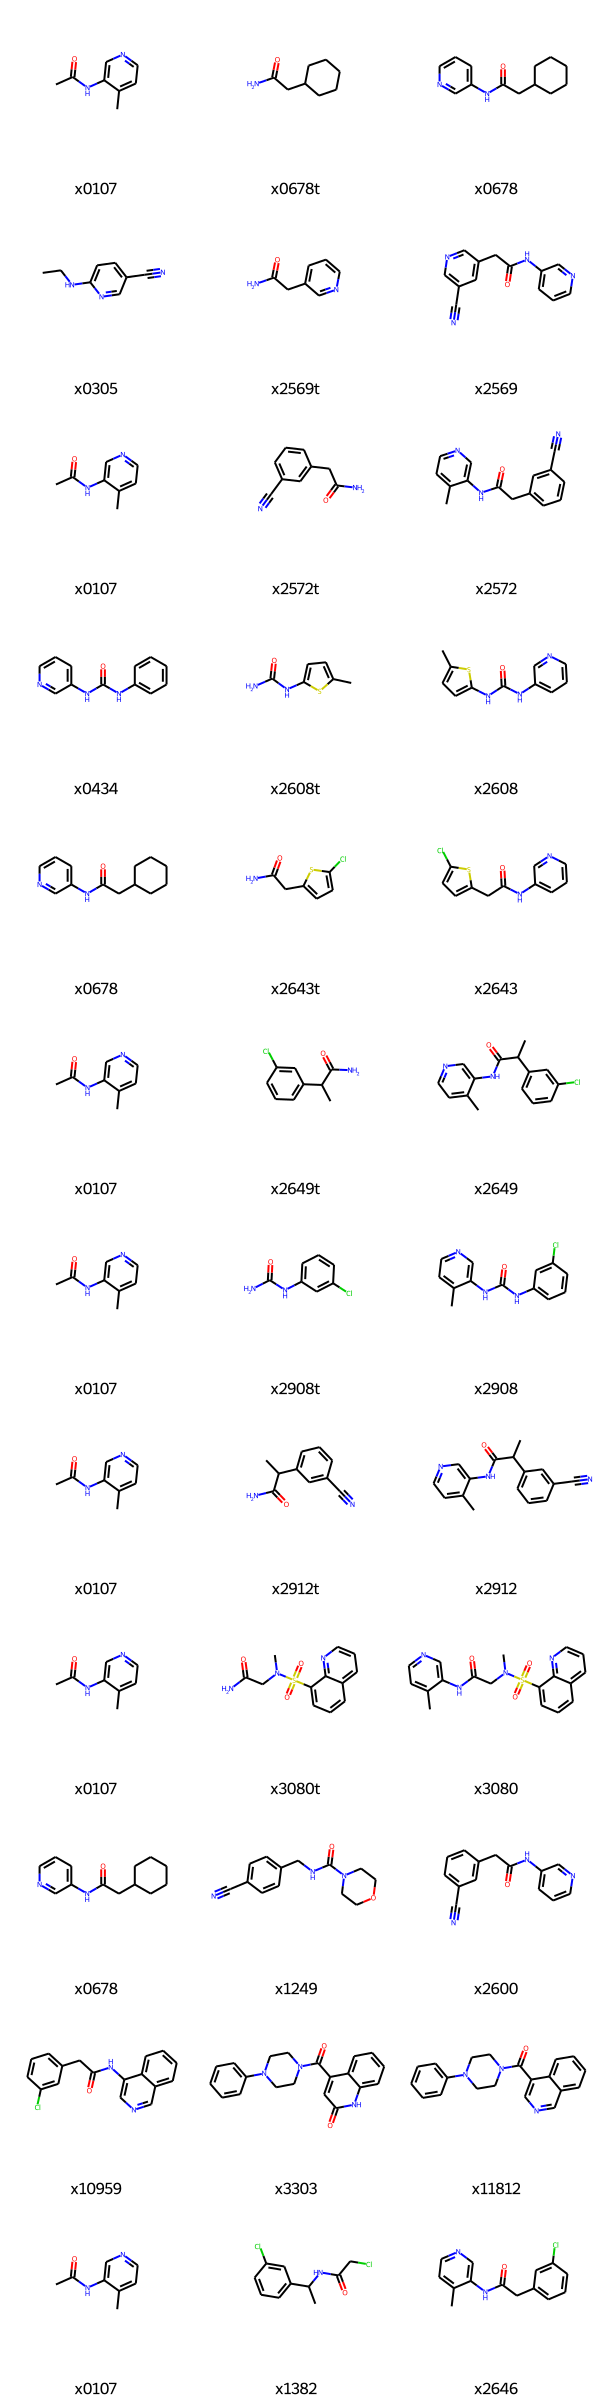

In [5]:
# visualise the test set molecules
all_mols = []
all_mol_ids = []

for fa, fb, mol, fa_id, fb_id, target_id in zip(fraga_mols, fragb_mols, target_mols, fraga_ids, fragb_ids, target_ids):
    all_mols.append(fa)
    all_mols.append(fb)
    all_mols.append(mol)
    all_mol_ids.append(fa_id)
    all_mol_ids.append(fb_id)
    all_mol_ids.append(target_id)

Draw.MolsToGridImage(all_mols, legends=all_mol_ids)  # 't' indicates where the fragment is a truncated version of the taret molecule

Check that the smiles of all the molecules exist in the network (as nodes)

In [6]:
Nodes(fraga_smiles, fraga_ids).check_for_nodes()
Nodes(fragb_smiles, fragb_ids).check_for_nodes()
Nodes(target_smiles, target_ids).check_for_nodes()

12 of 12 fragments present in network
12 of 12 fragments present in network
12 of 12 fragments present in network


## Synthon generation and fragment expansion

Classes Merge (and MergePairs) generate all the synthons of fragment B and expand fragment A. Will return a dataframe containing all the necessary data.

Fragment A is expanded using the synthons generated from the corresponding fragment B.

We can also calculate the reverse - for this example we will just expand fragment A.

In [7]:
merge = MergePairs(fraga_smiles, fragb_smiles, fraga_ids, fragb_ids)
results = merge.get_all_expansions()

Expanding fragment A: x0107 with synthons of fragment B: x0678t
Found 2 synthons
Synthon 0: found 112 expansions
Synthon 1: found 885 expansions
997 expansions from 2 out of 2 synthons

Expanding fragment A: x0305 with synthons of fragment B: x2569t
Found 2 synthons
Synthon 0: found 5 expansions
Synthon 1: found 15116 expansions
15121 expansions from 2 out of 2 synthons

Expanding fragment A: x0107 with synthons of fragment B: x2572t
Found 7 synthons
Synthon 0: found 112 expansions
Synthon 1: found 500 expansions
Synthon 2: found 0 expansions
Synthon 3: found 0 expansions
Synthon 4: found 2575 expansions
Synthon 5: found 0 expansions
Synthon 6: found 482 expansions
3669 expansions from 4 out of 7 synthons

Expanding fragment A: x0434 with synthons of fragment B: x2608t
Found 7 synthons
Synthon 0: found 18126 expansions
Synthon 1: found 0 expansions
Synthon 2: found 0 expansions
Synthon 3: found 293 expansions
Synthon 4: found 0 expansions
Synthon 5: found 42 expansions
Synthon 6: found

In [9]:
# remove the 't' representing truncation from Fragment B ID column - this will make it easier to get the files later
fragbs = [i for i in results['Fragment B ID']]
for i, f in enumerate(fragbs):
    f_new = f.replace('t', '')
    fragbs[i] = f_new

results['Fragment B ID'] = fragbs

In [10]:
results

,Merge,Fragment A ID,Fragment A smiles,Fragment B ID,Fragment B smiles,Synthon,Smiles
0,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)Cc1ncc2c(n1)CCCCC2=O
1,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1CCC2(C1)CC1(C2)OCCO1
2,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1CCNc2cc3c(cc21)OCCO3
3,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1C(=O)c2ccccc2Oc2ncccc21
4,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)Cc1nc2sc3c(c2c(=O)[nH]1)CCCC3
...,...,...,...,...,...,...,...
57461,x0107_x1382,x0107,CC(=O)Nc1cnccc1C,x1382,CC(NC(=O)CCl)c1cccc(Cl)c1,[Xe]c1cccc([Xe])c1,COCc1cccc(CC(=O)Nc2cnccc2C)c1
57462,x0107_x1382,x0107,CC(=O)Nc1cnccc1C,x1382,CC(NC(=O)CCl)c1cccc(Cl)c1,[Xe]c1cccc([Xe])c1,CC(=O)Nc1cccc(CN2CC3C4CCC(O4)C3C2)c1
57463,x0107_x1382,x0107,CC(=O)Nc1cnccc1C,x1382,CC(NC(=O)CCl)c1cccc(Cl)c1,[Xe]c1cccc([Xe])c1,Cc1cccc(CC(=O)Nc2ccc3[nH]c(=O)[nH]c3c2)c1
57464,x0107_x1382,x0107,CC(=O)Nc1cnccc1C,x1382,CC(NC(=O)CCl)c1cccc(Cl)c1,[Xe]c1cccc([Xe])c1,CC(=O)Nc1cccc(CN2CCC3(CCOC3)C2)c1


In [15]:
# add the target smiles back in - this will make later analysis easier
ID_dict = {}
smi_dict = {}

for ID, merge in zip(target_ids, results['Merge'].unique().tolist()):
    ID_dict[merge] = ID

for smi, merge in zip(target_smiles, results['Merge'].unique().tolist()):
    smi_dict[merge] = smi

In [21]:
def get_col(dict, merge):
    return dict[merge]

results['Target ID'] = results.apply(lambda x: get_col(ID_dict, x['Merge']), axis=1)
results['Target smiles'] = results.apply(lambda x: get_col(smi_dict, x['Merge']), axis=1)

In [23]:
# save this to a csv file in the data folder
results.to_csv('/home/sabsr3/xchem/fragment_network_merges/data/mergeResults.csv', index=False)

In [25]:
results

,Merge,Fragment A ID,Fragment A smiles,Fragment B ID,Fragment B smiles,Synthon,Smiles,Target ID,Target smiles
0,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)Cc1ncc2c(n1)CCCCC2=O,x0678,O=C(CC1CCCCC1)Nc1cccnc1
1,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1CCC2(C1)CC1(C2)OCCO1,x0678,O=C(CC1CCCCC1)Nc1cccnc1
2,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1CCNc2cc3c(cc21)OCCO3,x0678,O=C(CC1CCCCC1)Nc1cccnc1
3,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1C(=O)c2ccccc2Oc2ncccc21,x0678,O=C(CC1CCCCC1)Nc1cccnc1
4,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)Cc1nc2sc3c(c2c(=O)[nH]1)CCCC3,x0678,O=C(CC1CCCCC1)Nc1cccnc1
...,...,...,...,...,...,...,...,...,...
57461,x0107_x1382,x0107,CC(=O)Nc1cnccc1C,x1382,CC(NC(=O)CCl)c1cccc(Cl)c1,[Xe]c1cccc([Xe])c1,COCc1cccc(CC(=O)Nc2cnccc2C)c1,x2646,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1
57462,x0107_x1382,x0107,CC(=O)Nc1cnccc1C,x1382,CC(NC(=O)CCl)c1cccc(Cl)c1,[Xe]c1cccc([Xe])c1,CC(=O)Nc1cccc(CN2CC3C4CCC(O4)C3C2)c1,x2646,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1
57463,x0107_x1382,x0107,CC(=O)Nc1cnccc1C,x1382,CC(NC(=O)CCl)c1cccc(Cl)c1,[Xe]c1cccc([Xe])c1,Cc1cccc(CC(=O)Nc2ccc3[nH]c(=O)[nH]c3c2)c1,x2646,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1
57464,x0107_x1382,x0107,CC(=O)Nc1cnccc1C,x1382,CC(NC(=O)CCl)c1cccc(Cl)c1,[Xe]c1cccc([Xe])c1,CC(=O)Nc1cccc(CN2CCC3(CCOC3)C2)c1,x2646,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1
